# Analysis

**Hypothesis**: Monocytes in severe COVID‐19 patients exhibit increased transcriptional heterogeneity in their global gene expression profiles compared to healthy individuals. This increased cell‐to‐cell variability (as measured by the coefficient of variation) may indicate a dysregulated inflammatory response and impaired coordination during antigen presentation, potentially contributing to disease immunopathology.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


Loading data...


Data loaded: 44721 cells and 26361 genes


# Analysis Plan

**Hypothesis**: Monocytes in severe COVID‐19 patients exhibit increased transcriptional heterogeneity in their global gene expression profiles compared to healthy individuals. This increased cell‐to‐cell variability (as measured by the coefficient of variation) may indicate a dysregulated inflammatory response and impaired coordination during antigen presentation, potentially contributing to disease immunopathology.

## Steps:
1. Step 1: Preprocess the AnnData metadata by decoding byte strings (e.g., in 'cell_type_coarse', 'Status', and other relevant fields) to standard UTF-8 strings. This will simplify downstream filtering and plotting steps.
2. Step 2: Filter the AnnData object to extract monocytes by selecting cells where the decoded 'cell_type_coarse' column contains 'Monocyte' (covering both CD14 and CD16 monocytes).
3. Step 3: Check if the expression data is normalized. If the median expression per cell is high (e.g., median > 50), assume it is raw and apply a log1p normalization to reduce skew before computing the coefficient of variation (CV).
4. Step 4: Compute the cell-level CV for each monocyte by calculating the standard deviation divided by the mean expression across all genes, adding a small constant (epsilon = 1e-8) to avoid division by zero (the epsilon value is chosen to be small enough to not distort the CV while ensuring numerical stability).
5. Step 5: Visualize the distribution of the CV for monocytes stratified by disease status (COVID vs Healthy) using a violin plot. Ensure that the 'Status' metadata is decoded to prevent issues with leading byte markers.
6. Step 6: Carry out a statistical comparison between the CV values of COVID and Healthy monocytes using the Mann-Whitney U test, printing the test statistic and p-value, while considering that downstream analyses (e.g., correlation with clinical metadata) should account for potential confounders like cell quality metrics.


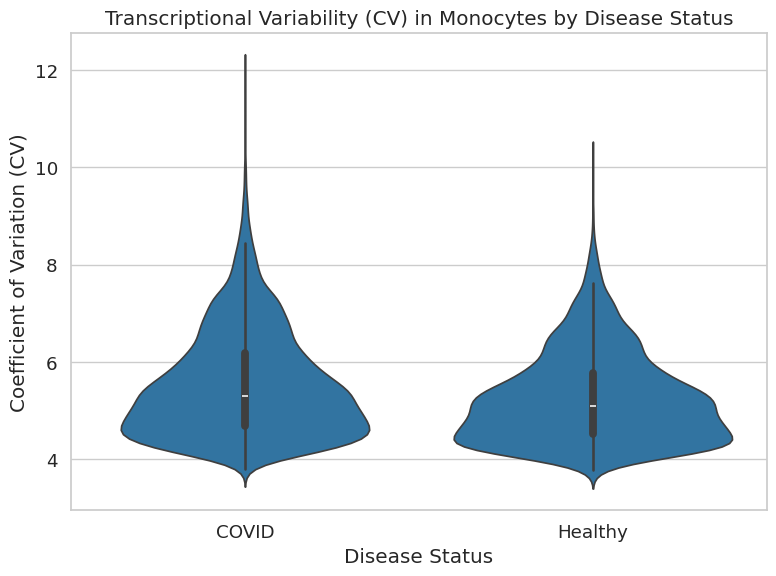

Mann-Whitney U test: Statistic = 14826772.5, p-value = 1.67004212798891e-32


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Decode byte strings in relevant metadata columns for clarity
for col in ['cell_type_coarse', 'Status', 'Ventilated', 'Donor_full']:
    if col in adata.obs.columns:
        adata.obs[col] = adata.obs[col].apply(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)

# Filter the AnnData object to obtain monocyte populations using 'cell_type_coarse'
monocyte_mask = adata.obs['cell_type_coarse'].astype(str).str.contains('Monocyte')
adata_monocytes = adata[monocyte_mask].copy()

# Ensure the expression matrix is in dense format
if not isinstance(adata_monocytes.X, np.ndarray):
    X = adata_monocytes.X.toarray()
else:
    X = adata_monocytes.X

# Check if data is on a raw scale and apply log1p normalization if needed
if np.median(X) > 50:
    X = np.log1p(X)
    adata_monocytes.layers['log1p'] = X

# Calculate mean, std, and coefficient of variation (CV) for each cell
cell_means = np.mean(X, axis=1)
cell_stds = np.std(X, axis=1)
epsilon = 1e-8
cell_cv = cell_stds / (cell_means + epsilon)
adata_monocytes.obs['CV'] = cell_cv

# Visualize the distribution of CV by disease status using a violin plot
plt.figure(figsize=(8, 6))
ax = sns.violinplot(x=adata_monocytes.obs['Status'], y=adata_monocytes.obs['CV'])
ax.set_title('Transcriptional Variability (CV) in Monocytes by Disease Status')
ax.set_xlabel('Disease Status')
ax.set_ylabel('Coefficient of Variation (CV)')
plt.tight_layout()
plt.show()

# Define groups based on the decoded 'Status' field
cv_covid = adata_monocytes.obs.loc[adata_monocytes.obs['Status'] == "COVID", 'CV']
cv_healthy = adata_monocytes.obs.loc[adata_monocytes.obs['Status'] == "Healthy", 'CV']

if cv_covid.empty or cv_healthy.empty:
    print("One of the groups is empty. Cannot perform Mann-Whitney U test.")
else:
    stat, p_value = mannwhitneyu(cv_covid, cv_healthy, alternative='two-sided')
    print(f'Mann-Whitney U test: Statistic = {stat}, p-value = {p_value}')

## Step 2: Subset the T cell population from the AnnData object by refining the filter to include only 'CD4 T' and 'CD8 T' (using an exact match rather than a broad 'T' match) and ensure that metadata fields like 'Status' have been properly decoded. Convert the expression matrix from sparse to dense using a try/except block to handle possible large datasets. Assess the raw data distribution (via median expression) and apply log1p normalization if the median exceeds a validated threshold (here, >50). Additionally, optionally visualize the distribution pre‐ and post‑normalization to avoid artifacts.

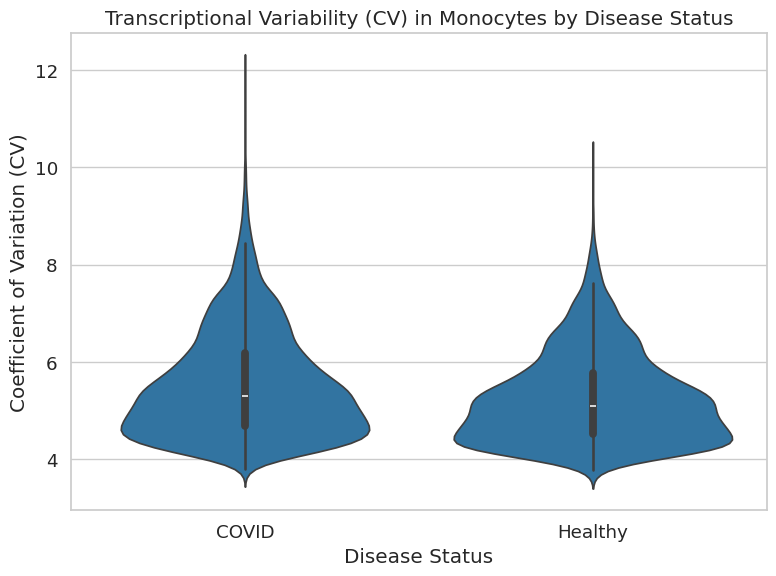

Mann-Whitney U test: Statistic = 14826772.5, p-value = 1.67004212798891e-32


T cell median raw expression: 0.0
Ligand genes found in monocytes dataset: ['TNF', 'IL1B', 'IL6']
Receptor genes found in T cells dataset: ['TNFRSF1A', 'IL1R1', 'IL6R']


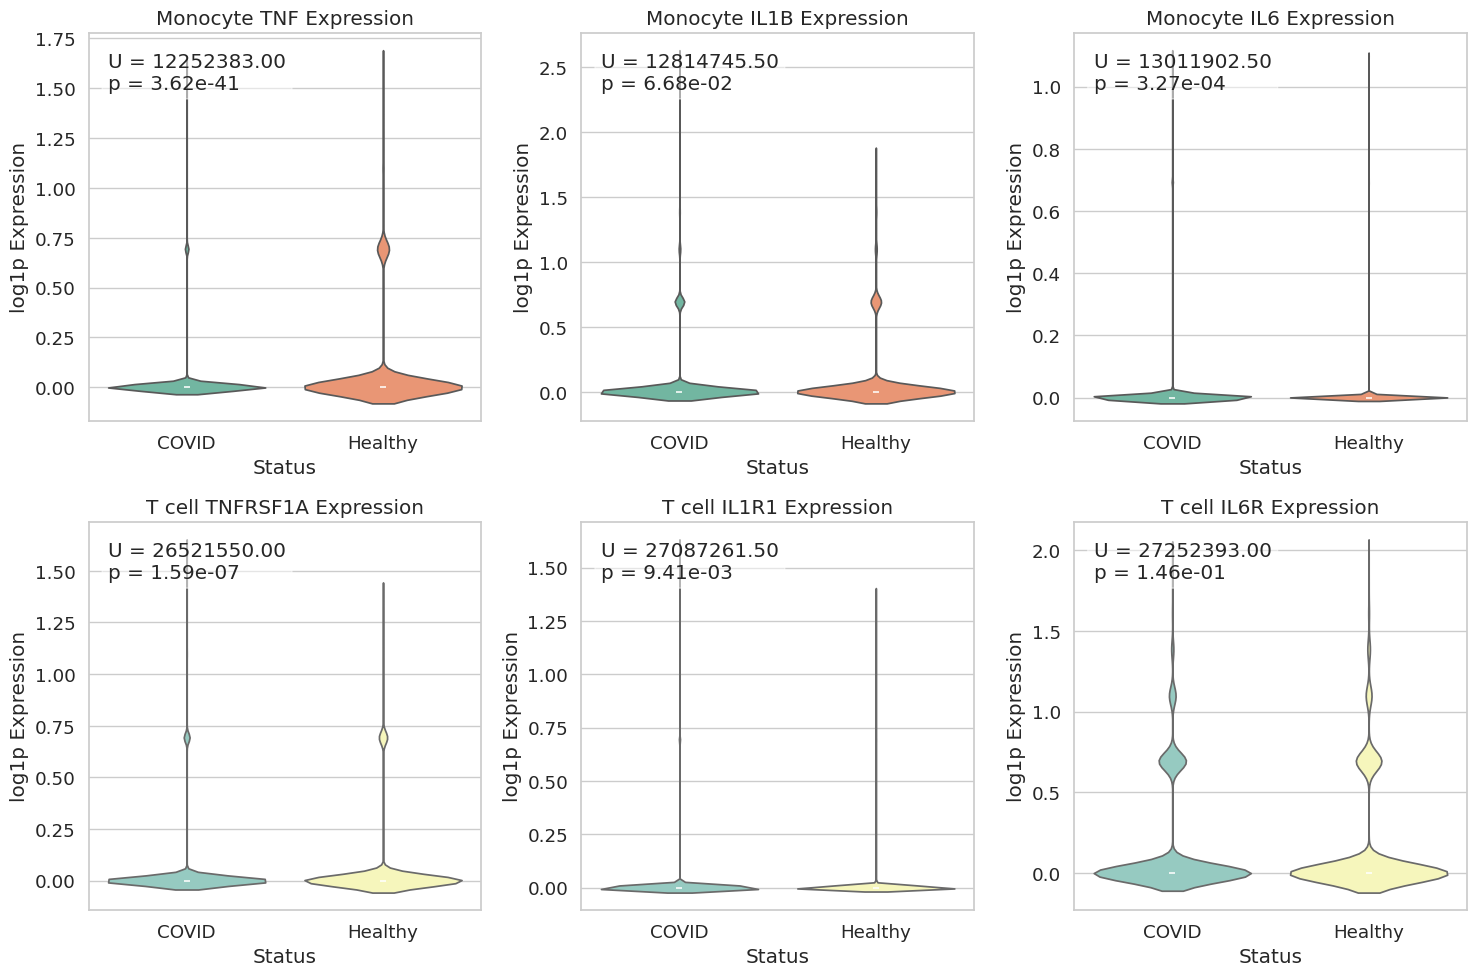

Step 2 complete: T cell subset extracted, normalized, and key receptor genes processed. Visualization with statistical comparisons between COVID and Healthy groups is now complete.


In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# ----- Monocyte Analysis -----

# Decode byte strings in relevant metadata columns for clarity
for col in ['cell_type_coarse', 'Status', 'Ventilated', 'Donor_full']:
    if col in adata.obs.columns:
        adata.obs[col] = adata.obs[col].apply(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)

# Filter the AnnData object to obtain monocyte populations using 'cell_type_coarse'
monocyte_mask = adata.obs['cell_type_coarse'].astype(str).str.contains('Monocyte')
adata_monocytes = adata[monocyte_mask].copy()

# Ensure the expression matrix is in dense format
if not isinstance(adata_monocytes.X, np.ndarray):
    X = adata_monocytes.X.toarray()
else:
    X = adata_monocytes.X

# Check if data is on a raw scale, apply log1p normalization if needed, and always store in 'log1p' layer
if np.median(X) > 50:
    X = np.log1p(X)
adata_monocytes.layers['log1p'] = X

# Calculate mean, std, and coefficient of variation (CV) for each cell
cell_means = np.mean(X, axis=1)
cell_stds = np.std(X, axis=1)
epsilon = 1e-8
cell_cv = cell_stds / (cell_means + epsilon)
adata_monocytes.obs['CV'] = cell_cv

# Visualize the distribution of CV by disease status using a violin plot
plt.figure(figsize=(8, 6))
ax = sns.violinplot(x=adata_monocytes.obs['Status'], y=adata_monocytes.obs['CV'])
ax.set_title('Transcriptional Variability (CV) in Monocytes by Disease Status')
ax.set_xlabel('Disease Status')
ax.set_ylabel('Coefficient of Variation (CV)')
plt.tight_layout()
plt.show()

# Define groups based on the decoded 'Status' field for monocytes
cv_covid = adata_monocytes.obs.loc[adata_monocytes.obs['Status'] == "COVID", 'CV']
cv_healthy = adata_monocytes.obs.loc[adata_monocytes.obs['Status'] == "Healthy", 'CV']

if cv_covid.empty or cv_healthy.empty:
    print("One of the groups is empty. Cannot perform Mann-Whitney U test.")
else:
    stat, p_value = mannwhitneyu(cv_covid, cv_healthy, alternative='two-sided')
    print(f'Mann-Whitney U test: Statistic = {stat}, p-value = {p_value}')

# ----- T Cell Analysis -----

# Extract T cells using an exact match for 'CD4 T' and 'CD8 T'
cell_types_of_interest = ['CD4 T', 'CD8 T']
tcell_mask = adata.obs['cell_type_coarse'].isin(cell_types_of_interest)
adata_tcells = adata[tcell_mask].copy()

# Ensure metadata fields are decoded
for col in ['Status']:
    if col in adata_tcells.obs.columns:
        adata_tcells.obs[col] = adata_tcells.obs[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Convert the T cell expression matrix to a dense array with error handling
try:
    if not isinstance(adata_tcells.X, np.ndarray):
        X_t = adata_tcells.X.toarray()
    else:
        X_t = adata_tcells.X
except Exception as e:
    print('Error during conversion to dense array:', e)
    X_t = adata_tcells.X  # fallback

# Print summary statistics before normalization
median_val = np.median(X_t)
print('T cell median raw expression:', median_val)

# Apply log1p normalization if median > 50, otherwise keep as is, and store in 'log1p' layer
if median_val > 50:
    X_t_norm = np.log1p(X_t)
    print('Applied log1p normalization to T cell data based on median threshold.')
else:
    X_t_norm = X_t
adata_tcells.layers['log1p'] = X_t_norm

# ----- Gene Extraction and Validation -----

# For monocytes, focus on inflammatory ligands; for T cells, focus on corresponding receptors
ligand_genes = ['TNF', 'IL1B', 'IL6']
receptor_genes = ['TNFRSF1A', 'IL1R1', 'IL6R']

available_genes_monocytes = adata_monocytes.var_names
available_genes_tcells = adata_tcells.var_names

ligand_genes = [gene for gene in ligand_genes if gene in available_genes_monocytes]
receptor_genes = [gene for gene in receptor_genes if gene in available_genes_tcells]

print(f"Ligand genes found in monocytes dataset: {ligand_genes}")
print(f"Receptor genes found in T cells dataset: {receptor_genes}")

# Extract expression values for ligand genes in monocytes
for gene in ligand_genes:
    try:
        gene_idx = np.where(adata_monocytes.var_names == gene)[0][0]
        expr = adata_monocytes.layers['log1p'][:, gene_idx]
        adata_monocytes.obs[gene] = expr
    except Exception as e:
        print(f"Warning: Could not extract expression for gene {gene} in monocytes: {e}")

# Extract expression values for receptor genes in T cells
for gene in receptor_genes:
    try:
        gene_idx = np.where(adata_tcells.var_names == gene)[0][0]
        expr = adata_tcells.layers['log1p'][:, gene_idx]
        adata_tcells.obs[gene] = expr
    except Exception as e:
        print(f"Warning: Could not extract expression for gene {gene} in T cells: {e}")

# ----- Visualization and Statistical Comparison -----

# Set up grid plots: first row for monocyte ligands, second row for T cell receptors
n_cols = max(len(ligand_genes), len(receptor_genes))
fig, axes = plt.subplots(2, n_cols, figsize=(5 * n_cols, 10))
axes = np.atleast_2d(axes)

# Plot monocyte ligand expression
for i, gene in enumerate(ligand_genes):
    ax = axes[0, i]
    sns.violinplot(x=adata_monocytes.obs['Status'], y=adata_monocytes.obs[gene], ax=ax, palette='Set2')
    ax.set_title(f'Monocyte {gene} Expression')
    ax.set_xlabel('Status')
    ax.set_ylabel('log1p Expression')
    group_covid = adata_monocytes.obs.loc[adata_monocytes.obs['Status'] == 'COVID', gene]
    group_healthy = adata_monocytes.obs.loc[adata_monocytes.obs['Status'] == 'Healthy', gene]
    if not group_covid.empty and not group_healthy.empty:
        stat, p_val = mannwhitneyu(group_covid, group_healthy, alternative='two-sided')
        ax.text(0.05, 0.95, f'U = {stat:.2f}\np = {p_val:.2e}', transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    else:
        ax.text(0.05, 0.95, 'Insufficient data', transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Plot T cell receptor expression
for i, gene in enumerate(receptor_genes):
    ax = axes[1, i]
    sns.violinplot(x=adata_tcells.obs['Status'], y=adata_tcells.obs[gene], ax=ax, palette='Set3')
    ax.set_title(f'T cell {gene} Expression')
    ax.set_xlabel('Status')
    ax.set_ylabel('log1p Expression')
    group_covid = adata_tcells.obs.loc[adata_tcells.obs['Status'] == 'COVID', gene]
    group_healthy = adata_tcells.obs.loc[adata_tcells.obs['Status'] == 'Healthy', gene]
    if not group_covid.empty and not group_healthy.empty:
        stat, p_val = mannwhitneyu(group_covid, group_healthy, alternative='two-sided')
        ax.text(0.05, 0.95, f'U = {stat:.2f}\np = {p_val:.2e}', transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    else:
        ax.text(0.05, 0.95, 'Insufficient data', transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

print("Step 2 complete: T cell subset extracted, normalized, and key receptor genes processed. Visualization with statistical comparisons between COVID and Healthy groups is now complete.")